In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [ ]:
my_data_dir = '../input/plant-seedlings-classification'

In [ ]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

In [ ]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [ ]:
os.listdir(test_path)

In [ ]:
CATEGORIES = os.listdir(train_path)
CATEGORIES

In [ ]:
len(CATEGORIES)

Renaming train set image files (Once done files are renamed so no need to run again)

In [ ]:
train = []
for category_id, category in enumerate(CATEGORIES):
    #count = 0
    for file in os.listdir(os.path.join(train_path, category)):
        #renamed_to = category+'.'+str(count)+'.png'
        train.append(['train/{}/{}'.format(category, file),file,category_id, category])
        #os.rename((train_dir+category+"/"+file),(train_dir+category+"/"+renamed_to))
        #count = count + 1
#train = pd.DataFrame(train, columns=['file','filename', 'category_id', 'category','renamed_to'])
train = pd.DataFrame(train, columns=['file','filename', 'category_id', 'category'])
train.shape

Renaming train set image files(Once done files are renamed so no need to run again)

In [ ]:
test = []

#count = 0
for file in os.listdir(test_path):
  #renamed_to = str(count)+'.png'
  test.append(['test/{}'.format(file),file])
  #os.rename((test_dir+file),(test_dir+renamed_to))
  #count = count + 1
test = pd.DataFrame(test, columns=['filepath','file'])
test.shape

In [ ]:
train.tail(5)

In [ ]:
test.head(5)

# create model

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,Lambda,BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

Freeze layers in VGG-19

In [ ]:
SEED = 42
WIDTH = 370
HEIGHT = 370
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

In [ ]:
def freezeLayersVGG(vgg_model):
    trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            trainable = True
            
        if trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg_model

Identify layers in VGG 19

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model = freezeLayersVGG(vgg_model)

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

Freeze layers in Resnet 50

In [ ]:
def freezeLayersResNet(resnet_model):
    trainable = False
    for layer in resnet_model.layers:
        if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
            trainable = True
            
        if trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return resnet_model

Identify layers in Resnet 50

In [ ]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = resnet.layers[-1].output
output = Flatten()(output)
resnet_model = Model(resnet.input, output)

freezeLayersResNet(resnet_model)
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

# Function for printing history

In [ ]:
def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

#Create the model from the scratch

In [ ]:
def createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs):
    print("Create Model")

    existing_model = 0 
    
    if pretrainedModel == "ResNet-50":
        existing_model = ResNet50(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        if fineTune == True:
            existing_model = freezeLayersResNet(existing_model)
        else:
            for layer in existing_model.layers:
                existing_model.trainable = False  # freeze feature extracting layers of ResNet 50
    elif pretrainedModel == "VGG-19":
        existing_model = VGG19(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        
        if fineTune == True:
            existing_model = freezeLayersVGG(existing_model)
        else:
            for layer in existing_model.layers:
                layer.trainable = False  # freeze feature extracting layers of VGG 19

    output = existing_model.layers[-1].output
    output = Flatten()(output)
    transfer_model = Model(existing_model.input, output)

    model = Sequential()
    model.add(transfer_model)
    model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch

    
    for i in range(0,number_of_hidden_layers):
        model.add(Dense(512))
        model.add(Activation(activation))
        model.add(Dropout(0.5))
        model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch


    model.add(Dense(12, activation='softmax'))

    if optimizer == 'SGD':
        opt = SGD(lr=learning_rate, decay=learning_rate / epochs)
    elif optimizer == 'Adam':
        opt = Adam(lr=learning_rate, decay=learning_rate / epochs)

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()
    return model

Train model function with 5 fold cross validation

In [ ]:
def trainModel(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, cross_validation_folds, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True)
    
    datagen_valid = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True)
    
        
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    models = []
    iteration = 1
    
    t = images.category_id
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):
        annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
        checkpoint = ModelCheckpoint('/kaggle/working/model.h5', verbose=1, save_best_only=True)

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")
        
        model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)

        print("======================================")
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory=my_data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory=my_data_dir,
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit_generator(generator=train_generator,
                            validation_data = valid_generator, 
                            steps_per_epoch=STEP_SIZE_TRAIN, 
                            validation_steps=STEP_SIZE_VALID, 
                            epochs=epochs, 
                            callbacks=[annealer, checkpoint],
                            verbose=1)
        
        scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        models.append(model)
        
        printHistory(history, pretrainedModel, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    # Save best model.
    best_model_index = np.argmax(scores, axis=0) 
    best_model= models[best_model_index]
    best_model.save('/kaggle/working/best_model')

    return train_generator.class_indices
    

#Training with Resnet50

In [ ]:
class_indices = trainModel(
    train,
    pretrainedModel = "ResNet-50", #ResNet-50
    fineTune = False,
    batch_size =32,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 4,
    optimizer = 'Adam',
    epochs = 30
)

In [ ]:
Train Model
Cross validation
======================================
Iteration =  1
======================================
Create Model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
functional_5 (Functional)    (None, 294912)            23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 294912)            1179648   
_________________________________________________________________
dense (Dense)                (None, 512)               150995456 
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                6156      
=================================================================
Total params: 176,565,132
Trainable params: 152,383,500
Non-trainable params: 24,181,632
_________________________________________________________________
======================================
Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 2.8833 - accuracy: 0.1489
Epoch 00001: val_loss improved from inf to 2.03370, saving model to /kaggle/working/model.h5
118/118 [==============================] - 281s 2s/step - loss: 2.8833 - accuracy: 0.1489 - val_loss: 2.0337 - val_accuracy: 0.3341
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 2.3243 - accuracy: 0.2524
Epoch 00002: val_loss improved from 2.03370 to 1.51770, saving model to /kaggle/working/model.h5
118/118 [==============================] - 224s 2s/step - loss: 2.3243 - accuracy: 0.2524 - val_loss: 1.5177 - val_accuracy: 0.4774
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 1.8853 - accuracy: 0.3676
Epoch 00003: val_loss improved from 1.51770 to 1.17815, saving model to /kaggle/working/model.h5
118/118 [==============================] - 221s 2s/step - loss: 1.8853 - accuracy: 0.3676 - val_loss: 1.1781 - val_accuracy: 0.5722
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 1.6065 - accuracy: 0.4445
Epoch 00004: val_loss improved from 1.17815 to 0.98040, saving model to /kaggle/working/model.h5
118/118 [==============================] - 224s 2s/step - loss: 1.6065 - accuracy: 0.4445 - val_loss: 0.9804 - val_accuracy: 0.6789
Epoch 5/30
118/118 [==============================] - ETA: 0s - loss: 1.3551 - accuracy: 0.5090
Epoch 00005: val_loss improved from 0.98040 to 0.84665, saving model to /kaggle/working/model.h5
118/118 [==============================] - 218s 2s/step - loss: 1.3551 - accuracy: 0.5090 - val_loss: 0.8467 - val_accuracy: 0.7101
Epoch 6/30
118/118 [==============================] - ETA: 0s - loss: 1.2837 - accuracy: 0.5281
Epoch 00006: val_loss improved from 0.84665 to 0.76550, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 1.2837 - accuracy: 0.5281 - val_loss: 0.7655 - val_accuracy: 0.7274
Epoch 7/30
118/118 [==============================] - ETA: 0s - loss: 1.1167 - accuracy: 0.5918
Epoch 00007: val_loss improved from 0.76550 to 0.71240, saving model to /kaggle/working/model.h5
118/118 [==============================] - 217s 2s/step - loss: 1.1167 - accuracy: 0.5918 - val_loss: 0.7124 - val_accuracy: 0.7565
Epoch 8/30
118/118 [==============================] - ETA: 0s - loss: 1.0327 - accuracy: 0.6285
Epoch 00008: val_loss improved from 0.71240 to 0.63544, saving model to /kaggle/working/model.h5
118/118 [==============================] - 211s 2s/step - loss: 1.0327 - accuracy: 0.6285 - val_loss: 0.6354 - val_accuracy: 0.7877
Epoch 9/30
118/118 [==============================] - ETA: 0s - loss: 0.9950 - accuracy: 0.6433
Epoch 00009: val_loss improved from 0.63544 to 0.58659, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 0.9950 - accuracy: 0.6433 - val_loss: 0.5866 - val_accuracy: 0.7920
Epoch 10/30
118/118 [==============================] - ETA: 0s - loss: 0.9227 - accuracy: 0.6789
Epoch 00010: val_loss improved from 0.58659 to 0.54421, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 0.9227 - accuracy: 0.6789 - val_loss: 0.5442 - val_accuracy: 0.8050
Epoch 11/30
118/118 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.6868
Epoch 00011: val_loss improved from 0.54421 to 0.50537, saving model to /kaggle/working/model.h5
118/118 [==============================] - 211s 2s/step - loss: 0.8891 - accuracy: 0.6868 - val_loss: 0.5054 - val_accuracy: 0.8190
Epoch 12/30
118/118 [==============================] - ETA: 0s - loss: 0.8114 - accuracy: 0.7030
Epoch 00012: val_loss improved from 0.50537 to 0.49036, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 0.8114 - accuracy: 0.7030 - val_loss: 0.4904 - val_accuracy: 0.8341
Epoch 13/30
118/118 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.7232
Epoch 00013: val_loss improved from 0.49036 to 0.45483, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 0.7824 - accuracy: 0.7232 - val_loss: 0.4548 - val_accuracy: 0.8373
Epoch 14/30
118/118 [==============================] - ETA: 0s - loss: 0.7735 - accuracy: 0.7317
Epoch 00014: val_loss did not improve from 0.45483
118/118 [==============================] - 208s 2s/step - loss: 0.7735 - accuracy: 0.7317 - val_loss: 0.4801 - val_accuracy: 0.8384
Epoch 15/30
118/118 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.7503
Epoch 00015: val_loss did not improve from 0.45483
118/118 [==============================] - 204s 2s/step - loss: 0.7150 - accuracy: 0.7503 - val_loss: 0.4640 - val_accuracy: 0.8534
Epoch 16/30
118/118 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.7617
Epoch 00016: val_loss improved from 0.45483 to 0.43037, saving model to /kaggle/working/model.h5
118/118 [==============================] - 211s 2s/step - loss: 0.6957 - accuracy: 0.7617 - val_loss: 0.4304 - val_accuracy: 0.8502
Epoch 17/30
118/118 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7646
Epoch 00017: val_loss did not improve from 0.43037
118/118 [==============================] - 206s 2s/step - loss: 0.6553 - accuracy: 0.7646 - val_loss: 0.4477 - val_accuracy: 0.8448
Epoch 18/30
118/118 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7553
Epoch 00018: val_loss improved from 0.43037 to 0.42931, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 0.6790 - accuracy: 0.7553 - val_loss: 0.4293 - val_accuracy: 0.8545
Epoch 19/30
118/118 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7749
Epoch 00019: val_loss did not improve from 0.42931
118/118 [==============================] - 209s 2s/step - loss: 0.6506 - accuracy: 0.7749 - val_loss: 0.4585 - val_accuracy: 0.8438
Epoch 20/30
118/118 [==============================] - ETA: 0s - loss: 0.6370 - accuracy: 0.7776
Epoch 00020: val_loss did not improve from 0.42931
118/118 [==============================] - 207s 2s/step - loss: 0.6370 - accuracy: 0.7776 - val_loss: 0.4582 - val_accuracy: 0.8556
Epoch 21/30
118/118 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.7757
Epoch 00021: val_loss improved from 0.42931 to 0.39446, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 0.6427 - accuracy: 0.7757 - val_loss: 0.3945 - val_accuracy: 0.8728
Epoch 22/30
118/118 [==============================] - ETA: 0s - loss: 0.6175 - accuracy: 0.7856
Epoch 00022: val_loss did not improve from 0.39446
118/118 [==============================] - 206s 2s/step - loss: 0.6175 - accuracy: 0.7856 - val_loss: 0.4239 - val_accuracy: 0.8491
Epoch 23/30
118/118 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.7845
Epoch 00023: val_loss did not improve from 0.39446
118/118 [==============================] - 203s 2s/step - loss: 0.6108 - accuracy: 0.7845 - val_loss: 0.3981 - val_accuracy: 0.8653
Epoch 24/30
118/118 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7893
Epoch 00024: val_loss improved from 0.39446 to 0.38516, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.6121 - accuracy: 0.7893 - val_loss: 0.3852 - val_accuracy: 0.8750
Epoch 25/30
118/118 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7911
Epoch 00025: val_loss did not improve from 0.38516
118/118 [==============================] - 210s 2s/step - loss: 0.6038 - accuracy: 0.7911 - val_loss: 0.4009 - val_accuracy: 0.8599
Epoch 26/30
118/118 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.7972
Epoch 00026: val_loss did not improve from 0.38516
118/118 [==============================] - 209s 2s/step - loss: 0.5833 - accuracy: 0.7972 - val_loss: 0.3992 - val_accuracy: 0.8718
Epoch 27/30
118/118 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.7986
Epoch 00027: val_loss did not improve from 0.38516
118/118 [==============================] - 207s 2s/step - loss: 0.5637 - accuracy: 0.7986 - val_loss: 0.4176 - val_accuracy: 0.8491
Epoch 28/30
118/118 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8063
Epoch 00028: val_loss improved from 0.38516 to 0.36858, saving model to /kaggle/working/model.h5
118/118 [==============================] - 221s 2s/step - loss: 0.5608 - accuracy: 0.8063 - val_loss: 0.3686 - val_accuracy: 0.8653
Epoch 29/30
118/118 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.8171
Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00029: val_loss did not improve from 0.36858
118/118 [==============================] - 207s 2s/step - loss: 0.5493 - accuracy: 0.8171 - val_loss: 0.3769 - val_accuracy: 0.8728
Epoch 30/30
118/118 [==============================] - ETA: 0s - loss: 0.5109 - accuracy: 0.8171
Epoch 00030: val_loss improved from 0.36858 to 0.36376, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 0.5109 - accuracy: 0.8171 - val_loss: 0.3638 - val_accuracy: 0.8858
Accuarcy accuracy: 88.69%
======================================
Iteration =  2
======================================
Create Model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
functional_7 (Functional)    (None, 294912)            23587712  
_________________________________________________________________
batch_normalization_5 (Batch (None, 294912)            1179648   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               150995456 
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_6 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 12)                6156      
=================================================================
Total params: 176,565,132
Trainable params: 152,383,500
Non-trainable params: 24,181,632
_________________________________________________________________
======================================
Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 2.8636 - accuracy: 0.1457
Epoch 00001: val_loss improved from inf to 2.08180, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 2.8636 - accuracy: 0.1457 - val_loss: 2.0818 - val_accuracy: 0.3103
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 2.2982 - accuracy: 0.2699
Epoch 00002: val_loss improved from 2.08180 to 1.46135, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 2.2982 - accuracy: 0.2699 - val_loss: 1.4614 - val_accuracy: 0.4838
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 1.8917 - accuracy: 0.3676
Epoch 00003: val_loss improved from 1.46135 to 1.16692, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 1.8917 - accuracy: 0.3676 - val_loss: 1.1669 - val_accuracy: 0.5636
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 1.5995 - accuracy: 0.4379
Epoch 00004: val_loss improved from 1.16692 to 1.00815, saving model to /kaggle/working/model.h5
118/118 [==============================] - 218s 2s/step - loss: 1.5995 - accuracy: 0.4379 - val_loss: 1.0081 - val_accuracy: 0.6422
Epoch 5/30
118/118 [==============================] - ETA: 0s - loss: 1.3721 - accuracy: 0.4960
Epoch 00005: val_loss improved from 1.00815 to 0.80984, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 1.3721 - accuracy: 0.4960 - val_loss: 0.8098 - val_accuracy: 0.6961
Epoch 6/30
118/118 [==============================] - ETA: 0s - loss: 1.2639 - accuracy: 0.5483
Epoch 00006: val_loss improved from 0.80984 to 0.72256, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 1.2639 - accuracy: 0.5483 - val_loss: 0.7226 - val_accuracy: 0.7166
Epoch 7/30
118/118 [==============================] - ETA: 0s - loss: 1.1594 - accuracy: 0.5804
Epoch 00007: val_loss improved from 0.72256 to 0.70521, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 1.1594 - accuracy: 0.5804 - val_loss: 0.7052 - val_accuracy: 0.7414
Epoch 8/30
118/118 [==============================] - ETA: 0s - loss: 1.0365 - accuracy: 0.6287
Epoch 00008: val_loss improved from 0.70521 to 0.64493, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 1.0365 - accuracy: 0.6287 - val_loss: 0.6449 - val_accuracy: 0.7866
Epoch 9/30
118/118 [==============================] - ETA: 0s - loss: 0.9709 - accuracy: 0.6521
Epoch 00009: val_loss improved from 0.64493 to 0.58569, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.9709 - accuracy: 0.6521 - val_loss: 0.5857 - val_accuracy: 0.7877
Epoch 10/30
118/118 [==============================] - ETA: 0s - loss: 0.9128 - accuracy: 0.6760
Epoch 00010: val_loss improved from 0.58569 to 0.57111, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.9128 - accuracy: 0.6760 - val_loss: 0.5711 - val_accuracy: 0.8060
Epoch 11/30
118/118 [==============================] - ETA: 0s - loss: 0.8831 - accuracy: 0.6858
Epoch 00011: val_loss improved from 0.57111 to 0.48898, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.8831 - accuracy: 0.6858 - val_loss: 0.4890 - val_accuracy: 0.8276
Epoch 12/30
118/118 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.6982
Epoch 00012: val_loss did not improve from 0.48898
118/118 [==============================] - 202s 2s/step - loss: 0.8348 - accuracy: 0.6982 - val_loss: 0.4948 - val_accuracy: 0.8287
Epoch 13/30
118/118 [==============================] - ETA: 0s - loss: 0.7708 - accuracy: 0.7266
Epoch 00013: val_loss improved from 0.48898 to 0.46688, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 0.7708 - accuracy: 0.7266 - val_loss: 0.4669 - val_accuracy: 0.8341
Epoch 14/30
118/118 [==============================] - ETA: 0s - loss: 0.7694 - accuracy: 0.7362
Epoch 00014: val_loss improved from 0.46688 to 0.45016, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.7694 - accuracy: 0.7362 - val_loss: 0.4502 - val_accuracy: 0.8330
Epoch 15/30
118/118 [==============================] - ETA: 0s - loss: 0.7424 - accuracy: 0.7328
Epoch 00015: val_loss improved from 0.45016 to 0.40552, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 0.7424 - accuracy: 0.7328 - val_loss: 0.4055 - val_accuracy: 0.8567
Epoch 16/30
118/118 [==============================] - ETA: 0s - loss: 0.7235 - accuracy: 0.7460
Epoch 00016: val_loss did not improve from 0.40552
118/118 [==============================] - 206s 2s/step - loss: 0.7235 - accuracy: 0.7460 - val_loss: 0.4331 - val_accuracy: 0.8481
Epoch 17/30
118/118 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7638
Epoch 00017: val_loss did not improve from 0.40552
118/118 [==============================] - 212s 2s/step - loss: 0.6626 - accuracy: 0.7638 - val_loss: 0.4207 - val_accuracy: 0.8599
Epoch 18/30
118/118 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7673
Epoch 00018: val_loss improved from 0.40552 to 0.39697, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 0.6715 - accuracy: 0.7673 - val_loss: 0.3970 - val_accuracy: 0.8804
Epoch 19/30
118/118 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7699
Epoch 00019: val_loss improved from 0.39697 to 0.38919, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 0.6680 - accuracy: 0.7699 - val_loss: 0.3892 - val_accuracy: 0.8588
Epoch 20/30
118/118 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7805
Epoch 00020: val_loss improved from 0.38919 to 0.36122, saving model to /kaggle/working/model.h5
118/118 [==============================] - 216s 2s/step - loss: 0.6376 - accuracy: 0.7805 - val_loss: 0.3612 - val_accuracy: 0.8718
Epoch 21/30
118/118 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.7818
Epoch 00021: val_loss did not improve from 0.36122
118/118 [==============================] - 209s 2s/step - loss: 0.6363 - accuracy: 0.7818 - val_loss: 0.3891 - val_accuracy: 0.8696
Epoch 22/30
118/118 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7898
Epoch 00022: val_loss did not improve from 0.36122
118/118 [==============================] - 210s 2s/step - loss: 0.6042 - accuracy: 0.7898 - val_loss: 0.3885 - val_accuracy: 0.8470
Epoch 23/30
118/118 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.7901
Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00023: val_loss did not improve from 0.36122
118/118 [==============================] - 208s 2s/step - loss: 0.5940 - accuracy: 0.7901 - val_loss: 0.3762 - val_accuracy: 0.8610
Epoch 24/30
118/118 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7914
Epoch 00024: val_loss improved from 0.36122 to 0.36109, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.5777 - accuracy: 0.7914 - val_loss: 0.3611 - val_accuracy: 0.8610
Epoch 25/30
118/118 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.8049
Epoch 00025: val_loss improved from 0.36109 to 0.33643, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.5831 - accuracy: 0.8049 - val_loss: 0.3364 - val_accuracy: 0.8782
Epoch 26/30
118/118 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8108
Epoch 00026: val_loss did not improve from 0.33643
118/118 [==============================] - 203s 2s/step - loss: 0.5466 - accuracy: 0.8108 - val_loss: 0.3645 - val_accuracy: 0.8653
Epoch 27/30
118/118 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.8126
Epoch 00027: val_loss did not improve from 0.33643
118/118 [==============================] - 200s 2s/step - loss: 0.5424 - accuracy: 0.8126 - val_loss: 0.3588 - val_accuracy: 0.8804
Epoch 28/30
118/118 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.8063
Epoch 00028: val_loss improved from 0.33643 to 0.33043, saving model to /kaggle/working/model.h5
118/118 [==============================] - 217s 2s/step - loss: 0.5404 - accuracy: 0.8063 - val_loss: 0.3304 - val_accuracy: 0.8944
Epoch 29/30
118/118 [==============================] - ETA: 0s - loss: 0.5080 - accuracy: 0.8190
Epoch 00029: val_loss improved from 0.33043 to 0.32747, saving model to /kaggle/working/model.h5
118/118 [==============================] - 207s 2s/step - loss: 0.5080 - accuracy: 0.8190 - val_loss: 0.3275 - val_accuracy: 0.8944
Epoch 30/30
118/118 [==============================] - ETA: 0s - loss: 0.4824 - accuracy: 0.8312
Epoch 00030: val_loss did not improve from 0.32747
118/118 [==============================] - 202s 2s/step - loss: 0.4824 - accuracy: 0.8312 - val_loss: 0.3332 - val_accuracy: 0.8836
Accuarcy accuracy: 88.04%
======================================
Iteration =  3
======================================
Create Model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
functional_9 (Functional)    (None, 294912)            23587712  
_________________________________________________________________
batch_normalization_10 (Batc (None, 294912)            1179648   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               150995456 
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_9 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)               2048      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_11 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 12)                6156      
=================================================================
Total params: 176,565,132
Trainable params: 152,383,500
Non-trainable params: 24,181,632
_________________________________________________________________
======================================
Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 2.8883 - accuracy: 0.1428
Epoch 00001: val_loss improved from inf to 1.97444, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 2.8883 - accuracy: 0.1428 - val_loss: 1.9744 - val_accuracy: 0.3481
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 2.3276 - accuracy: 0.2524
Epoch 00002: val_loss improved from 1.97444 to 1.49830, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 2.3276 - accuracy: 0.2524 - val_loss: 1.4983 - val_accuracy: 0.4806
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 1.8770 - accuracy: 0.3583
Epoch 00003: val_loss improved from 1.49830 to 1.12829, saving model to /kaggle/working/model.h5
118/118 [==============================] - 207s 2s/step - loss: 1.8770 - accuracy: 0.3583 - val_loss: 1.1283 - val_accuracy: 0.5959
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 1.5850 - accuracy: 0.4406
Epoch 00004: val_loss improved from 1.12829 to 1.01932, saving model to /kaggle/working/model.h5
118/118 [==============================] - 207s 2s/step - loss: 1.5850 - accuracy: 0.4406 - val_loss: 1.0193 - val_accuracy: 0.6175
Epoch 5/30
118/118 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.5088
Epoch 00005: val_loss improved from 1.01932 to 0.80840, saving model to /kaggle/working/model.h5
118/118 [==============================] - 207s 2s/step - loss: 1.3572 - accuracy: 0.5088 - val_loss: 0.8084 - val_accuracy: 0.7058
Epoch 6/30
118/118 [==============================] - ETA: 0s - loss: 1.2436 - accuracy: 0.5555
Epoch 00006: val_loss improved from 0.80840 to 0.72287, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 1.2436 - accuracy: 0.5555 - val_loss: 0.7229 - val_accuracy: 0.7457
Epoch 7/30
118/118 [==============================] - ETA: 0s - loss: 1.0964 - accuracy: 0.6054
Epoch 00007: val_loss improved from 0.72287 to 0.64388, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 1.0964 - accuracy: 0.6054 - val_loss: 0.6439 - val_accuracy: 0.7683
Epoch 8/30
118/118 [==============================] - ETA: 0s - loss: 1.0273 - accuracy: 0.6388
Epoch 00008: val_loss improved from 0.64388 to 0.57681, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 1.0273 - accuracy: 0.6388 - val_loss: 0.5768 - val_accuracy: 0.8017
Epoch 9/30
118/118 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.6571
Epoch 00009: val_loss improved from 0.57681 to 0.53255, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 0.9516 - accuracy: 0.6571 - val_loss: 0.5325 - val_accuracy: 0.8082
Epoch 10/30
118/118 [==============================] - ETA: 0s - loss: 0.8996 - accuracy: 0.6754
Epoch 00010: val_loss did not improve from 0.53255
118/118 [==============================] - 203s 2s/step - loss: 0.8996 - accuracy: 0.6754 - val_loss: 0.5730 - val_accuracy: 0.8071
Epoch 11/30
118/118 [==============================] - ETA: 0s - loss: 0.8452 - accuracy: 0.7022
Epoch 00011: val_loss improved from 0.53255 to 0.48696, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.8452 - accuracy: 0.7022 - val_loss: 0.4870 - val_accuracy: 0.8341
Epoch 12/30
118/118 [==============================] - ETA: 0s - loss: 0.8009 - accuracy: 0.7237
Epoch 00012: val_loss improved from 0.48696 to 0.44576, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.8009 - accuracy: 0.7237 - val_loss: 0.4458 - val_accuracy: 0.8438
Epoch 13/30
118/118 [==============================] - ETA: 0s - loss: 0.7998 - accuracy: 0.7163
Epoch 00013: val_loss improved from 0.44576 to 0.43510, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.7998 - accuracy: 0.7163 - val_loss: 0.4351 - val_accuracy: 0.8405
Epoch 14/30
118/118 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.7375
Epoch 00014: val_loss did not improve from 0.43510
118/118 [==============================] - 203s 2s/step - loss: 0.7456 - accuracy: 0.7375 - val_loss: 0.4458 - val_accuracy: 0.8567
Epoch 15/30
118/118 [==============================] - ETA: 0s - loss: 0.7264 - accuracy: 0.7410
Epoch 00015: val_loss improved from 0.43510 to 0.39596, saving model to /kaggle/working/model.h5
118/118 [==============================] - 207s 2s/step - loss: 0.7264 - accuracy: 0.7410 - val_loss: 0.3960 - val_accuracy: 0.8664
Epoch 16/30
118/118 [==============================] - ETA: 0s - loss: 0.7432 - accuracy: 0.7465
Epoch 00016: val_loss did not improve from 0.39596
118/118 [==============================] - 202s 2s/step - loss: 0.7432 - accuracy: 0.7465 - val_loss: 0.3964 - val_accuracy: 0.8642
Epoch 17/30
118/118 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.7760
Epoch 00017: val_loss improved from 0.39596 to 0.37665, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.6402 - accuracy: 0.7760 - val_loss: 0.3767 - val_accuracy: 0.8642
Epoch 18/30
118/118 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.7572
Epoch 00018: val_loss improved from 0.37665 to 0.37270, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.6886 - accuracy: 0.7572 - val_loss: 0.3727 - val_accuracy: 0.8621
Epoch 19/30
118/118 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7654
Epoch 00019: val_loss did not improve from 0.37270
118/118 [==============================] - 205s 2s/step - loss: 0.6670 - accuracy: 0.7654 - val_loss: 0.3847 - val_accuracy: 0.8707
Epoch 20/30
118/118 [==============================] - ETA: 0s - loss: 0.6241 - accuracy: 0.7760
Epoch 00020: val_loss did not improve from 0.37270
118/118 [==============================] - 201s 2s/step - loss: 0.6241 - accuracy: 0.7760 - val_loss: 0.3769 - val_accuracy: 0.8599
Epoch 21/30
118/118 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.7749
Epoch 00021: val_loss improved from 0.37270 to 0.35816, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 0.6415 - accuracy: 0.7749 - val_loss: 0.3582 - val_accuracy: 0.8696
Epoch 22/30
118/118 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7885
Epoch 00022: val_loss improved from 0.35816 to 0.34367, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.6357 - accuracy: 0.7885 - val_loss: 0.3437 - val_accuracy: 0.8739
Epoch 23/30
118/118 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7925
Epoch 00023: val_loss did not improve from 0.34367
118/118 [==============================] - 203s 2s/step - loss: 0.5984 - accuracy: 0.7925 - val_loss: 0.3652 - val_accuracy: 0.8847
Epoch 24/30
118/118 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7845
Epoch 00024: val_loss improved from 0.34367 to 0.34118, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.6049 - accuracy: 0.7845 - val_loss: 0.3412 - val_accuracy: 0.8761
Epoch 25/30
118/118 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.7856
Epoch 00025: val_loss did not improve from 0.34118
118/118 [==============================] - 204s 2s/step - loss: 0.6016 - accuracy: 0.7856 - val_loss: 0.3561 - val_accuracy: 0.8685
Epoch 26/30
118/118 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.8015
Epoch 00026: val_loss improved from 0.34118 to 0.31757, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 0.5838 - accuracy: 0.8015 - val_loss: 0.3176 - val_accuracy: 0.8772
Epoch 27/30
118/118 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.8047
Epoch 00027: val_loss improved from 0.31757 to 0.31541, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.5886 - accuracy: 0.8047 - val_loss: 0.3154 - val_accuracy: 0.8836
Epoch 28/30
118/118 [==============================] - ETA: 0s - loss: 0.5598 - accuracy: 0.7959
Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00028: val_loss did not improve from 0.31541
118/118 [==============================] - 205s 2s/step - loss: 0.5598 - accuracy: 0.7959 - val_loss: 0.3524 - val_accuracy: 0.8750
Epoch 29/30
118/118 [==============================] - ETA: 0s - loss: 0.5591 - accuracy: 0.8044
Epoch 00029: val_loss did not improve from 0.31541
118/118 [==============================] - 204s 2s/step - loss: 0.5591 - accuracy: 0.8044 - val_loss: 0.3326 - val_accuracy: 0.8750
Epoch 30/30
118/118 [==============================] - ETA: 0s - loss: 0.4970 - accuracy: 0.8238
Epoch 00030: val_loss improved from 0.31541 to 0.30786, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.4970 - accuracy: 0.8238 - val_loss: 0.3079 - val_accuracy: 0.8858
Accuarcy accuracy: 88.69%
======================================
Iteration =  4
======================================
Create Model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
functional_11 (Functional)   (None, 294912)            23587712  
_________________________________________________________________
batch_normalization_15 (Batc (None, 294912)            1179648   
_________________________________________________________________
dense_15 (Dense)             (None, 512)               150995456 
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 512)               2048      
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 12)                6156      
=================================================================
Total params: 176,565,132
Trainable params: 152,383,500
Non-trainable params: 24,181,632
_________________________________________________________________
======================================
Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 2.9163 - accuracy: 0.1377
Epoch 00001: val_loss improved from inf to 2.21694, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 2.9163 - accuracy: 0.1377 - val_loss: 2.2169 - val_accuracy: 0.3200
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 2.3177 - accuracy: 0.2596
Epoch 00002: val_loss improved from 2.21694 to 1.49622, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 2.3177 - accuracy: 0.2596 - val_loss: 1.4962 - val_accuracy: 0.4720
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 1.8541 - accuracy: 0.3575
Epoch 00003: val_loss improved from 1.49622 to 1.16451, saving model to /kaggle/working/model.h5
118/118 [==============================] - 211s 2s/step - loss: 1.8541 - accuracy: 0.3575 - val_loss: 1.1645 - val_accuracy: 0.5506
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 1.5736 - accuracy: 0.4440
Epoch 00004: val_loss improved from 1.16451 to 0.99597, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 1.5736 - accuracy: 0.4440 - val_loss: 0.9960 - val_accuracy: 0.6325
Epoch 5/30
118/118 [==============================] - ETA: 0s - loss: 1.3829 - accuracy: 0.5048
Epoch 00005: val_loss improved from 0.99597 to 0.81287, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 1.3829 - accuracy: 0.5048 - val_loss: 0.8129 - val_accuracy: 0.6918
Epoch 6/30
118/118 [==============================] - ETA: 0s - loss: 1.2323 - accuracy: 0.5552
Epoch 00006: val_loss improved from 0.81287 to 0.73315, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 1.2323 - accuracy: 0.5552 - val_loss: 0.7332 - val_accuracy: 0.7435
Epoch 7/30
118/118 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.5945
Epoch 00007: val_loss improved from 0.73315 to 0.72270, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 1.1148 - accuracy: 0.5945 - val_loss: 0.7227 - val_accuracy: 0.7425
Epoch 8/30
118/118 [==============================] - ETA: 0s - loss: 1.0699 - accuracy: 0.6024
Epoch 00008: val_loss improved from 0.72270 to 0.60201, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 1.0699 - accuracy: 0.6024 - val_loss: 0.6020 - val_accuracy: 0.7985
Epoch 9/30
118/118 [==============================] - ETA: 0s - loss: 1.0084 - accuracy: 0.6401
Epoch 00009: val_loss improved from 0.60201 to 0.53590, saving model to /kaggle/working/model.h5
118/118 [==============================] - 215s 2s/step - loss: 1.0084 - accuracy: 0.6401 - val_loss: 0.5359 - val_accuracy: 0.8190
Epoch 10/30
118/118 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.6656
Epoch 00010: val_loss improved from 0.53590 to 0.51151, saving model to /kaggle/working/model.h5
118/118 [==============================] - 211s 2s/step - loss: 0.9400 - accuracy: 0.6656 - val_loss: 0.5115 - val_accuracy: 0.8157
Epoch 11/30
118/118 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.6741
Epoch 00011: val_loss improved from 0.51151 to 0.49185, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.8902 - accuracy: 0.6741 - val_loss: 0.4919 - val_accuracy: 0.8211
Epoch 12/30
118/118 [==============================] - ETA: 0s - loss: 0.8172 - accuracy: 0.7160
Epoch 00012: val_loss improved from 0.49185 to 0.43757, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.8172 - accuracy: 0.7160 - val_loss: 0.4376 - val_accuracy: 0.8459
Epoch 13/30
118/118 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.7184
Epoch 00013: val_loss improved from 0.43757 to 0.41820, saving model to /kaggle/working/model.h5
118/118 [==============================] - 217s 2s/step - loss: 0.8040 - accuracy: 0.7184 - val_loss: 0.4182 - val_accuracy: 0.8459
Epoch 14/30
118/118 [==============================] - ETA: 0s - loss: 0.7852 - accuracy: 0.7245
Epoch 00014: val_loss did not improve from 0.41820
118/118 [==============================] - 205s 2s/step - loss: 0.7852 - accuracy: 0.7245 - val_loss: 0.4242 - val_accuracy: 0.8448
Epoch 15/30
118/118 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.7418
Epoch 00015: val_loss did not improve from 0.41820
118/118 [==============================] - 203s 2s/step - loss: 0.7493 - accuracy: 0.7418 - val_loss: 0.4217 - val_accuracy: 0.8319
Epoch 16/30
118/118 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.7463
Epoch 00016: val_loss improved from 0.41820 to 0.39673, saving model to /kaggle/working/model.h5
118/118 [==============================] - 213s 2s/step - loss: 0.7333 - accuracy: 0.7463 - val_loss: 0.3967 - val_accuracy: 0.8599
Epoch 17/30
118/118 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.7513
Epoch 00017: val_loss did not improve from 0.39673
118/118 [==============================] - 202s 2s/step - loss: 0.6840 - accuracy: 0.7513 - val_loss: 0.4033 - val_accuracy: 0.8545
Epoch 18/30
118/118 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7614
Epoch 00018: val_loss improved from 0.39673 to 0.37921, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.6926 - accuracy: 0.7614 - val_loss: 0.3792 - val_accuracy: 0.8567
Epoch 19/30
118/118 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7683
Epoch 00019: val_loss did not improve from 0.37921
118/118 [==============================] - 202s 2s/step - loss: 0.6780 - accuracy: 0.7683 - val_loss: 0.3937 - val_accuracy: 0.8599
Epoch 20/30
118/118 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.7763
Epoch 00020: val_loss did not improve from 0.37921
118/118 [==============================] - 203s 2s/step - loss: 0.6492 - accuracy: 0.7763 - val_loss: 0.3914 - val_accuracy: 0.8631
Epoch 21/30
118/118 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7691
Epoch 00021: val_loss did not improve from 0.37921
118/118 [==============================] - 202s 2s/step - loss: 0.6615 - accuracy: 0.7691 - val_loss: 0.3926 - val_accuracy: 0.8642
Epoch 22/30
118/118 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7800
Epoch 00022: val_loss did not improve from 0.37921
118/118 [==============================] - 202s 2s/step - loss: 0.6333 - accuracy: 0.7800 - val_loss: 0.4036 - val_accuracy: 0.8610
Epoch 23/30
118/118 [==============================] - ETA: 0s - loss: 0.6111 - accuracy: 0.7853
Epoch 00023: val_loss improved from 0.37921 to 0.33291, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.6111 - accuracy: 0.7853 - val_loss: 0.3329 - val_accuracy: 0.8793
Epoch 24/30
118/118 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.7773
Epoch 00024: val_loss did not improve from 0.33291
118/118 [==============================] - 202s 2s/step - loss: 0.6231 - accuracy: 0.7773 - val_loss: 0.3625 - val_accuracy: 0.8685
Epoch 25/30
118/118 [==============================] - ETA: 0s - loss: 0.6162 - accuracy: 0.7880
Epoch 00025: val_loss did not improve from 0.33291
118/118 [==============================] - 203s 2s/step - loss: 0.6162 - accuracy: 0.7880 - val_loss: 0.3435 - val_accuracy: 0.8782
Epoch 26/30
118/118 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.7962
Epoch 00026: val_loss did not improve from 0.33291
118/118 [==============================] - 202s 2s/step - loss: 0.5856 - accuracy: 0.7962 - val_loss: 0.3495 - val_accuracy: 0.8728
Epoch 27/30
118/118 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.7941
Epoch 00027: val_loss did not improve from 0.33291
118/118 [==============================] - 202s 2s/step - loss: 0.5879 - accuracy: 0.7941 - val_loss: 0.3375 - val_accuracy: 0.8793
Epoch 28/30
118/118 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.7980
Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00028: val_loss did not improve from 0.33291
118/118 [==============================] - 203s 2s/step - loss: 0.5859 - accuracy: 0.7980 - val_loss: 0.3383 - val_accuracy: 0.8772
Epoch 29/30
118/118 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.8145
Epoch 00029: val_loss improved from 0.33291 to 0.32714, saving model to /kaggle/working/model.h5
118/118 [==============================] - 211s 2s/step - loss: 0.5376 - accuracy: 0.8145 - val_loss: 0.3271 - val_accuracy: 0.8815
Epoch 30/30
118/118 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.8198
Epoch 00030: val_loss did not improve from 0.32714
118/118 [==============================] - 208s 2s/step - loss: 0.5204 - accuracy: 0.8198 - val_loss: 0.3342 - val_accuracy: 0.8761
Accuarcy accuracy: 88.25%
======================================
Iteration =  5
======================================
Create Model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
functional_13 (Functional)   (None, 294912)            23587712  
_________________________________________________________________
batch_normalization_20 (Batc (None, 294912)            1179648   
_________________________________________________________________
dense_20 (Dense)             (None, 512)               150995456 
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 512)               2048      
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 512)               2048      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_19 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 512)               2048      
_________________________________________________________________
dense_24 (Dense)             (None, 12)                6156      
=================================================================
Total params: 176,565,132
Trainable params: 152,383,500
Non-trainable params: 24,181,632
_________________________________________________________________
======================================
Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.
Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 2.8916 - accuracy: 0.1497
Epoch 00001: val_loss improved from inf to 2.14445, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 2.8916 - accuracy: 0.1497 - val_loss: 2.1444 - val_accuracy: 0.3157
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 2.3703 - accuracy: 0.2508
Epoch 00002: val_loss improved from 2.14445 to 1.51686, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 2.3703 - accuracy: 0.2508 - val_loss: 1.5169 - val_accuracy: 0.4601
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 1.9075 - accuracy: 0.3588
Epoch 00003: val_loss improved from 1.51686 to 1.16876, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 1.9075 - accuracy: 0.3588 - val_loss: 1.1688 - val_accuracy: 0.5787
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 1.6141 - accuracy: 0.4408
Epoch 00004: val_loss improved from 1.16876 to 0.97164, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 1.6141 - accuracy: 0.4408 - val_loss: 0.9716 - val_accuracy: 0.6175
Epoch 5/30
118/118 [==============================] - ETA: 0s - loss: 1.3812 - accuracy: 0.5003
Epoch 00005: val_loss improved from 0.97164 to 0.85223, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 1.3812 - accuracy: 0.5003 - val_loss: 0.8522 - val_accuracy: 0.6940
Epoch 6/30
118/118 [==============================] - ETA: 0s - loss: 1.2621 - accuracy: 0.5438
Epoch 00006: val_loss improved from 0.85223 to 0.72889, saving model to /kaggle/working/model.h5
118/118 [==============================] - 210s 2s/step - loss: 1.2621 - accuracy: 0.5438 - val_loss: 0.7289 - val_accuracy: 0.7295
Epoch 7/30
118/118 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.5987
Epoch 00007: val_loss improved from 0.72889 to 0.62893, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 1.1287 - accuracy: 0.5987 - val_loss: 0.6289 - val_accuracy: 0.7694
Epoch 8/30
118/118 [==============================] - ETA: 0s - loss: 1.0216 - accuracy: 0.6377
Epoch 00008: val_loss improved from 0.62893 to 0.54511, saving model to /kaggle/working/model.h5
118/118 [==============================] - 215s 2s/step - loss: 1.0216 - accuracy: 0.6377 - val_loss: 0.5451 - val_accuracy: 0.7942
Epoch 9/30
118/118 [==============================] - ETA: 0s - loss: 0.9833 - accuracy: 0.6505
Epoch 00009: val_loss improved from 0.54511 to 0.52871, saving model to /kaggle/working/model.h5
118/118 [==============================] - 214s 2s/step - loss: 0.9833 - accuracy: 0.6505 - val_loss: 0.5287 - val_accuracy: 0.7996
Epoch 10/30
118/118 [==============================] - ETA: 0s - loss: 0.9680 - accuracy: 0.6651
Epoch 00010: val_loss improved from 0.52871 to 0.51715, saving model to /kaggle/working/model.h5
118/118 [==============================] - 219s 2s/step - loss: 0.9680 - accuracy: 0.6651 - val_loss: 0.5171 - val_accuracy: 0.8125
Epoch 11/30
118/118 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.6868
Epoch 00011: val_loss improved from 0.51715 to 0.43978, saving model to /kaggle/working/model.h5
118/118 [==============================] - 222s 2s/step - loss: 0.8778 - accuracy: 0.6868 - val_loss: 0.4398 - val_accuracy: 0.8470
Epoch 12/30
118/118 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.7086
Epoch 00012: val_loss improved from 0.43978 to 0.41241, saving model to /kaggle/working/model.h5
118/118 [==============================] - 216s 2s/step - loss: 0.8255 - accuracy: 0.7086 - val_loss: 0.4124 - val_accuracy: 0.8513
Epoch 13/30
118/118 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.7274
Epoch 00013: val_loss improved from 0.41241 to 0.37892, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.7879 - accuracy: 0.7274 - val_loss: 0.3789 - val_accuracy: 0.8556
Epoch 14/30
118/118 [==============================] - ETA: 0s - loss: 0.7777 - accuracy: 0.7269
Epoch 00014: val_loss did not improve from 0.37892
118/118 [==============================] - 203s 2s/step - loss: 0.7777 - accuracy: 0.7269 - val_loss: 0.3939 - val_accuracy: 0.8545
Epoch 15/30
118/118 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.7455
Epoch 00015: val_loss did not improve from 0.37892
118/118 [==============================] - 203s 2s/step - loss: 0.7342 - accuracy: 0.7455 - val_loss: 0.4042 - val_accuracy: 0.8534
Epoch 16/30
118/118 [==============================] - ETA: 0s - loss: 0.7370 - accuracy: 0.7394
Epoch 00016: val_loss did not improve from 0.37892
118/118 [==============================] - 201s 2s/step - loss: 0.7370 - accuracy: 0.7394 - val_loss: 0.3978 - val_accuracy: 0.8545
Epoch 17/30
118/118 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7667
Epoch 00017: val_loss did not improve from 0.37892
118/118 [==============================] - 203s 2s/step - loss: 0.6689 - accuracy: 0.7667 - val_loss: 0.3803 - val_accuracy: 0.8481
Epoch 18/30
118/118 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.7630
Epoch 00018: val_loss improved from 0.37892 to 0.35166, saving model to /kaggle/working/model.h5
118/118 [==============================] - 209s 2s/step - loss: 0.6934 - accuracy: 0.7630 - val_loss: 0.3517 - val_accuracy: 0.8707
Epoch 19/30
118/118 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.7641
Epoch 00019: val_loss did not improve from 0.35166
118/118 [==============================] - 203s 2s/step - loss: 0.6804 - accuracy: 0.7641 - val_loss: 0.3597 - val_accuracy: 0.8728
Epoch 20/30
118/118 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7696
Epoch 00020: val_loss improved from 0.35166 to 0.33908, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.6537 - accuracy: 0.7696 - val_loss: 0.3391 - val_accuracy: 0.8664
Epoch 21/30
118/118 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7643
Epoch 00021: val_loss did not improve from 0.33908
118/118 [==============================] - 208s 2s/step - loss: 0.6746 - accuracy: 0.7643 - val_loss: 0.3498 - val_accuracy: 0.8685
Epoch 22/30
118/118 [==============================] - ETA: 0s - loss: 0.6352 - accuracy: 0.7763
Epoch 00022: val_loss improved from 0.33908 to 0.33536, saving model to /kaggle/working/model.h5
118/118 [==============================] - 212s 2s/step - loss: 0.6352 - accuracy: 0.7763 - val_loss: 0.3354 - val_accuracy: 0.8739
Epoch 23/30
118/118 [==============================] - ETA: 0s - loss: 0.6149 - accuracy: 0.7935
Epoch 00023: val_loss did not improve from 0.33536
118/118 [==============================] - 205s 2s/step - loss: 0.6149 - accuracy: 0.7935 - val_loss: 0.3442 - val_accuracy: 0.8739
Epoch 24/30
118/118 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7872
Epoch 00024: val_loss did not improve from 0.33536
118/118 [==============================] - 202s 2s/step - loss: 0.6151 - accuracy: 0.7872 - val_loss: 0.3451 - val_accuracy: 0.8685
Epoch 25/30
118/118 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.7805
Epoch 00025: val_loss improved from 0.33536 to 0.32856, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.6297 - accuracy: 0.7805 - val_loss: 0.3286 - val_accuracy: 0.8858
Epoch 26/30
118/118 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.7962
Epoch 00026: val_loss did not improve from 0.32856
118/118 [==============================] - 204s 2s/step - loss: 0.5912 - accuracy: 0.7962 - val_loss: 0.3312 - val_accuracy: 0.8804
Epoch 27/30
118/118 [==============================] - ETA: 0s - loss: 0.6107 - accuracy: 0.7840
Epoch 00027: val_loss did not improve from 0.32856
118/118 [==============================] - 202s 2s/step - loss: 0.6107 - accuracy: 0.7840 - val_loss: 0.3348 - val_accuracy: 0.8858
Epoch 28/30
118/118 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.7959
Epoch 00028: val_loss did not improve from 0.32856
118/118 [==============================] - 202s 2s/step - loss: 0.5940 - accuracy: 0.7959 - val_loss: 0.3307 - val_accuracy: 0.8836
Epoch 29/30
118/118 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.8039
Epoch 00029: val_loss improved from 0.32856 to 0.30924, saving model to /kaggle/working/model.h5
118/118 [==============================] - 207s 2s/step - loss: 0.5582 - accuracy: 0.8039 - val_loss: 0.3092 - val_accuracy: 0.8804
Epoch 30/30
118/118 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7988
Epoch 00030: val_loss improved from 0.30924 to 0.29169, saving model to /kaggle/working/model.h5
118/118 [==============================] - 208s 2s/step - loss: 0.5697 - accuracy: 0.7988 - val_loss: 0.2917 - val_accuracy: 0.8879
Accuarcy accuracy: 89.01%
Accuracy: 88.53% (+/- 0.34%)






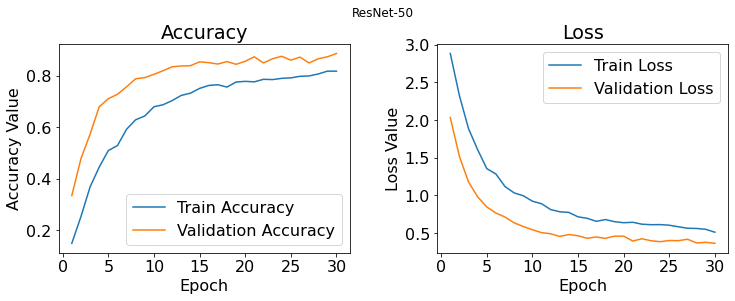
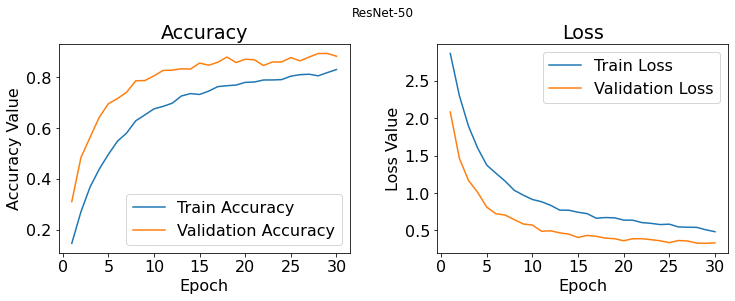
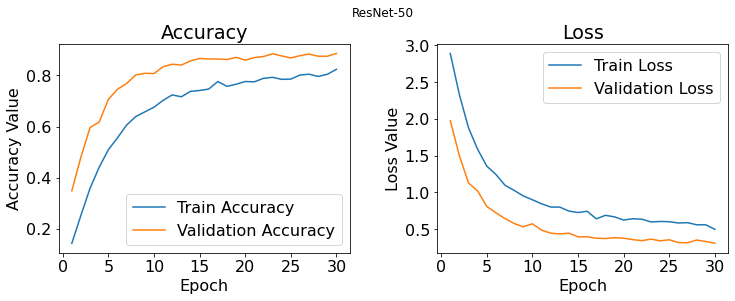
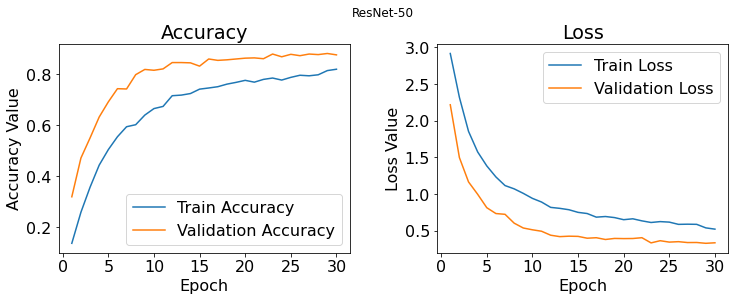
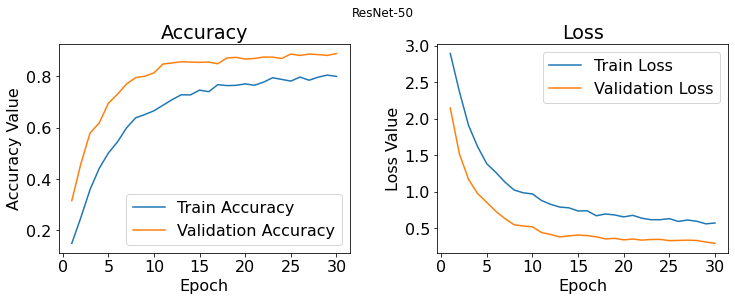

In [ ]:
class_indices={'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}
class_indices

In [ ]:
image_datagen_for_test = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True
                              )

test_generator=image_datagen_for_test.flow_from_dataframe(dataframe=test,
                                                  directory=test_path,
                                                  x_col="file",
                                                  y_col=None,
                                                  batch_size=1,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode=None,
                                                  target_size=INPUT_SHAPE[:2],
                                                  color_mode='rgb');

model = load_model('/kaggle/working/best_model/')
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)

# Final test predictions
predictions = model.predict_generator(test_generator,steps = nb_samples) 
predicted_class_indices=np.argmax(predictions,axis=1)

labels = dict((v,k) for k,v in class_indices.items())
predicted_labels = [labels[k] for k in predicted_class_indices]

results=pd.DataFrame({"file":filenames,
                      "species":predicted_labels})
print (results)
results.to_csv("submission.csv",index=False)

Found 794 validated image filenames.
794
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
              file            species
0    fea3da57c.png  Sugar beet       
1    fe9e87b78.png  Scentless Mayweed
2    fdea6b119.png  Loose Silky-bent 
3    fef2ade8c.png  Sugar beet       
4    ff65bc002.png  Charlock         
..             ...       ...         
789  e4a76885b.png  Maize            
790  e1abb4ff9.png  Sugar beet       
791  df521c0c0.png  Loose Silky-bent 
792  dd5ec63d9.png  Sugar beet       
793  25a4c427e.png  Loose Silky-bent 

[794 rows x 2 columns]

references 

https://www.kaggle.com/praanj/transfer-learning-vgg-19-resnet-50-with-kfold/
https://www.kaggle.com/c/plant-seedlings-classification/notebooks?competitionId=7880

https://www.kaggle.com/praanj/basic-keras-cnn-with-startified-kfold-evaluation

https://www.kaggle.com/kinsomaz/plant-seedling-classification-using-keras-0-9726

https://www.kaggle.com/kaiyungtan/plant-seedlings-classification

https://www.kaggle.com/akashwadhwaai/plant-seedlings-classification
